In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x20c620ba6d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

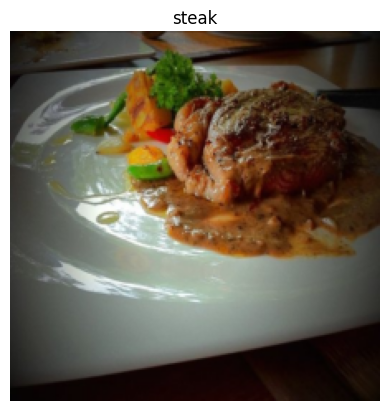

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


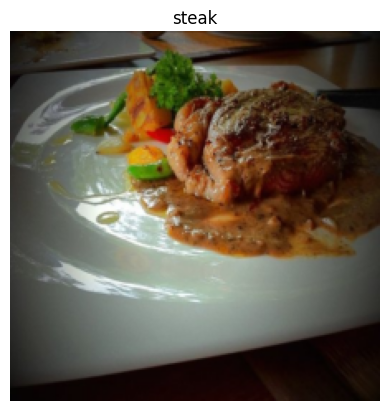

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

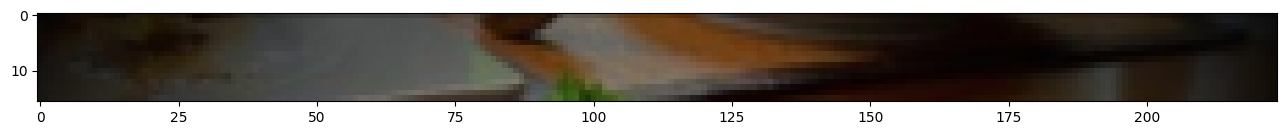

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


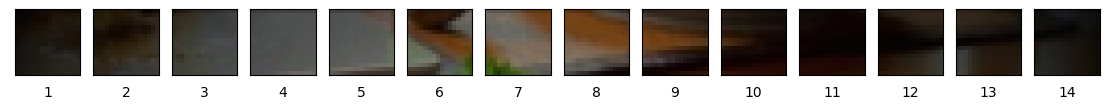

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


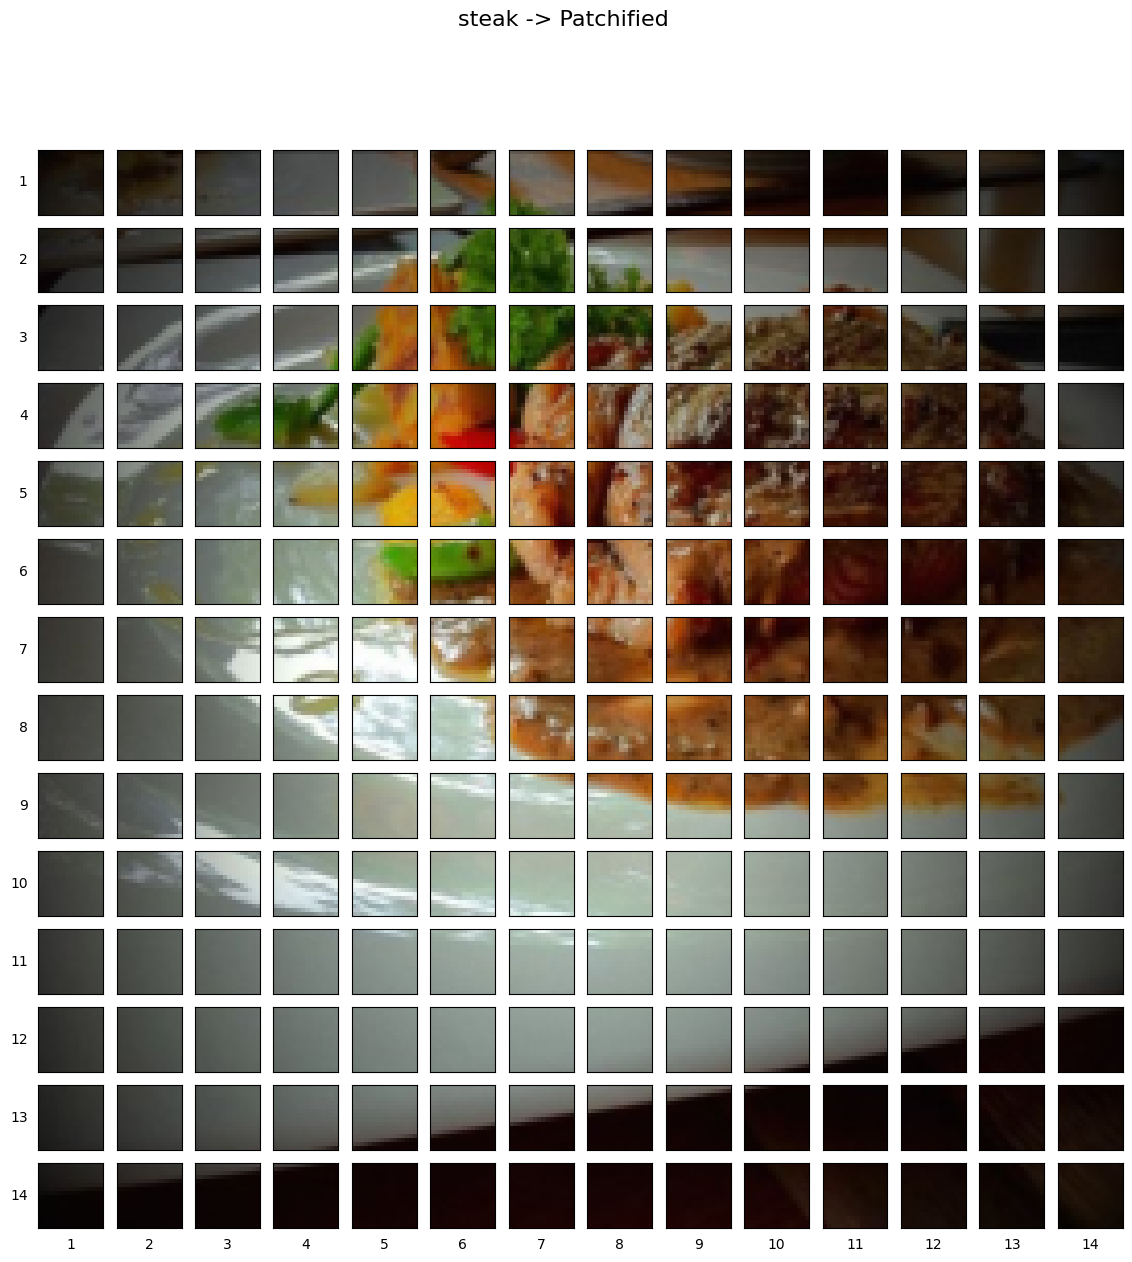

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

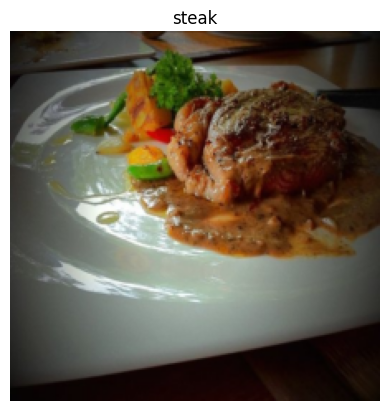

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

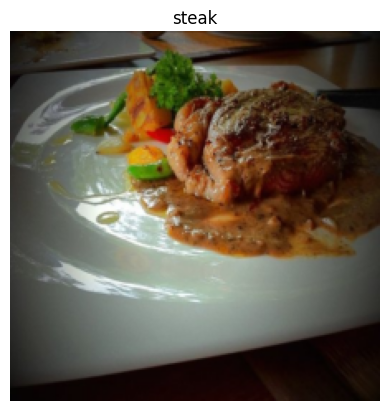

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [65, 221, 402, 731, 390]


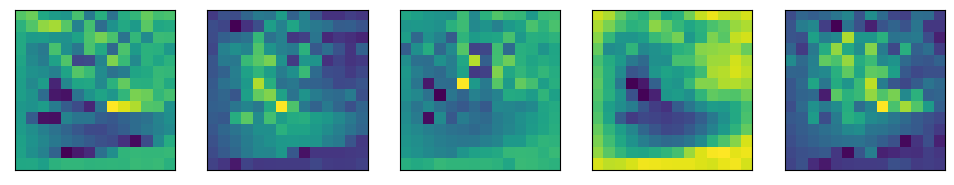

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-6.9554e-03,  9.6329e-03, -1.5523e-02, -4.6134e-02, -8.5223e-02,
           -4.0184e-02, -1.5399e-01, -7.1880e-02, -5.7711e-02,  8.5677e-03,
           -1.7633e-02, -1.2824e-02, -5.2603e-02, -3.4650e-02],
          [ 3.3705e-03, -5.3510e-02, -1.3211e-01, -1.6802e-01, -1.6115e-01,
           -1.0562e-01,  1.3372e-01,  6.7811e-02, -1.0790e-01, -6.1647e-02,
           -7.1423e-02, -6.6750e-02,  6.3741e-03, -5.8248e-02],
          [-1.6813e-02, -1.3597e-02, -1.5569e-01, -1.2237e-01, -1.6942e-01,
            2.6254e-02, -5.5531e-02, -1.1373e-02, -1.9488e-03, -2.2226e-01,
           -9.5056e-03, -1.0372e-01, -4.7147e-02,  1.9092e-02],
          [ 5.1863e-02, -3.8298e-02, -7.3346e-02,  3.4049e-02, -2.1564e-01,
           -2.8175e-01, -9.3626e-02, -4.4746e-02, -1.5876e-01,  1.0723e-01,
           -3.5278e-02, -9.6867e-03,  1.2119e-01, -6.1182e-02],
          [-4.5237e-02, -8.5318e-02, -2.8780e-02, -1.5288e-01, -1.3231e-01,
            3.3017e-02, -2.4362e-01,  7.6598e-04, -1.1244e-0

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


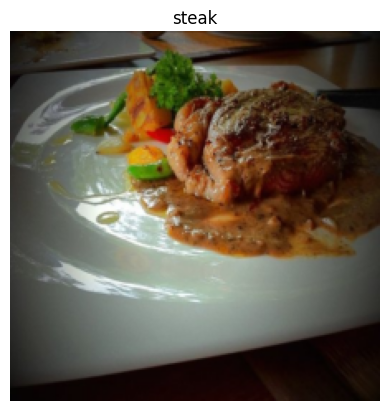

In [24]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [25]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


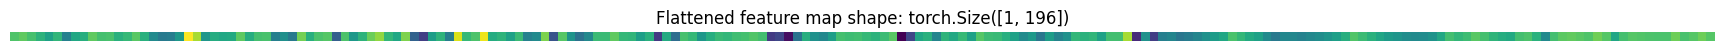

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-6.9554e-03,  9.6329e-03, -1.5523e-02, -4.6134e-02, -8.5223e-02,
          -4.0184e-02, -1.5399e-01, -7.1880e-02, -5.7711e-02,  8.5677e-03,
          -1.7633e-02, -1.2824e-02, -5.2603e-02, -3.4650e-02,  3.3705e-03,
          -5.3510e-02, -1.3211e-01, -1.6802e-01, -1.6115e-01, -1.0562e-01,
           1.3372e-01,  6.7811e-02, -1.0790e-01, -6.1647e-02, -7.1423e-02,
          -6.6750e-02,  6.3741e-03, -5.8248e-02, -1.6813e-02, -1.3597e-02,
          -1.5569e-01, -1.2237e-01, -1.6942e-01,  2.6254e-02, -5.5531e-02,
          -1.1373e-02, -1.9488e-03, -2.2226e-01, -9.5056e-03, -1.0372e-01,
          -4.7147e-02,  1.9092e-02,  5.1863e-02, -3.8298e-02, -7.3346e-02,
           3.4049e-02, -2.1564e-01, -2.8175e-01, -9.3626e-02, -4.4746e-02,
          -1.5876e-01,  1.0723e-01, -3.5278e-02, -9.6867e-03,  1.2119e-01,
          -6.1182e-02, -4.5237e-02, -8.5318e-02, -2.8780e-02, -1.5288e-01,
          -1.3231e-01,  3.3017e-02, -2.4362e-01,  7.6598e-04, -1.1244e-01,
          -1.8489e-01, -1

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(),
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.1362,  0.0362, -0.0603,  ...,  0.0932, -0.0200,  0.0238],
         [-0.1384,  0.0425, -0.1123,  ...,  0.1227, -0.0623,  0.0711],
         [-0.3195,  0.1003, -0.1293,  ...,  0.1989, -0.0833,  0.0819],
         ...,
         [-0.0641, -0.0172, -0.0395,  ...,  0.0335, -0.0239,  0.0326],
         [-0.0473,  0.0114, -0.0350,  ...,  0.0144, -0.0261,  0.0226],
         [-0.0860,  0.0017, -0.0281,  ...,  0.0453, -0.0432,  0.0219]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1362,  0.0362, -0.0603,  ...,  0.0932, -0.0200,  0.0238],
         [-0.1384,  0.0425, -0.1123,  ...,  0.1227, -0.0623,  0.0711],
         ...,
         [-0.0641, -0.0172, -0.0395,  ...,  0.0335, -0.0239,  0.0326],
         [-0.0473,  0.0114, -0.0350,  ...,  0.0144, -0.0261,  0.0226],
         [-0.0860,  0.0017, -0.0281,  ...,  0.0453, -0.0432,  0.0219]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1362,  0.0362, -0.0603,  ...,  0.0932, -0.0200,  0.0238],
          [-0.1384,  0.0425, -0.1123,  ...,  0.1227, -0.0623,  0.0711],
          ...,
          [-0.0641, -0.0172, -0.0395,  ...,  0.0335, -0.0239,  0.0326],
          [-0.0473,  0.0114, -0.0350,  ...,  0.0144, -0.0261,  0.0226],
          [-0.0860,  0.0017, -0.0281,  ...,  0.0453, -0.0432,  0.0219]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8638, 1.0362, 0.9397,  ..., 1.0932, 0.9800, 1.0238],
         [0.8616, 1.0425, 0.8877,  ..., 1.1227, 0.9377, 1.0711],
         ...,
         [0.9359, 0.9828, 0.9605,  ..., 1.0335, 0.9761, 1.0326],
         [0.9527, 1.0114, 0.9650,  ..., 1.0144, 0.9739, 1.0226],
         [0.9140, 1.0017, 0.9719,  ..., 1.0453, 0.9568, 1.0219]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [38]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [39]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8638, 1.0362, 0.9397,  ..., 1.0932, 0.9800, 1.0238],
         [0.8616, 1.0425, 0.8877,  ..., 1.1227, 0.9377, 1.0711],
         ...,
         [0.9359, 0.9828, 0.9605,  ..., 1.0335, 0.9761, 1.0326],
         [0.9527, 1.0114, 0.9650,  ..., 1.0144, 0.9739, 1.0226],
         [0.9140, 1.0017, 0.9719,  ..., 1.0453, 0.9568, 1.0219]]],
       grad_fn=<AddBackward0>)

In [40]:
patched_image_through_msa_block

tensor([[[-0.1993, -0.1435,  0.0609,  ..., -0.4299,  0.8944, -0.4661],
         [-0.1827, -0.1393,  0.0635,  ..., -0.4108,  0.9059, -0.4926],
         [-0.1834, -0.1339,  0.0681,  ..., -0.4162,  0.9103, -0.4920],
         ...,
         [-0.1798, -0.1496,  0.0674,  ..., -0.4096,  0.8992, -0.4876],
         [-0.1757, -0.1588,  0.0584,  ..., -0.4110,  0.8945, -0.4851],
         [-0.1755, -0.1512,  0.0593,  ..., -0.4144,  0.9049, -0.4913]]],
       grad_fn=<TransposeBackward0>)

In [41]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=0.1
                 ):
        super().__init__()
        
        # Create a norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout()
        )
        
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [42]:
mlp_block = MLPBlock()

# Pass the output of the MSA block through MLP
patch_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patch_image_through_mlp_block

tensor([[[-0.0282, -0.0298,  0.0000,  ..., -0.0000, -0.2648,  0.3978],
         [-0.0000, -0.0000,  0.4727,  ..., -0.1908, -0.0000,  0.0000],
         [ 0.0418, -0.0000,  0.0000,  ..., -0.0000, -0.3387,  0.0000],
         ...,
         [-0.2723, -0.0000,  0.0000,  ...,  0.1509, -0.3727,  0.0000],
         [-0.1572,  0.0000,  0.0000,  ...,  0.0000, -0.3143,  0.0000],
         [-0.0000, -0.0652,  0.0000,  ..., -0.2382, -0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)

## Creating an Encoder

In [43]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                embedding_dim: int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:float=0.1,
                attn_dropout:float=0.0):
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
            )
        
        # Create MLP block equation 3
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )
    
    def forward(self, x):
        x = self.msa_block(x) + x 
        x = self.mlp_block(x) + x
        return x

In [44]:
transformer_encoder_block = TransformerEncoderBlock()
summary(
    model=transformer_encoder_block, 
    input_size=(1, 197, 768), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=15, 
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multihead_attn)         --              [1, 197, 768]   2,362,368       True
├─MLPBlock (mlp_block)                             [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                            [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                             [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU (1)                               [1, 197,

In [45]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, 
    nhead=12, 
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

summary(
    model=torch_transformer_encoder_layer, 
    input_size=(1, 197, 768), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=15, 
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]   [1, 197, 768]   7,087,872       True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Setting up ViT

In [46]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels: int=3, 
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: int=0,
                 mlp_dropuout: float=0.1,
                 embedding_dropout: float=0.1,
                 num_classes: int=1000):
        super().__init__()
        
        # Make an assertion that the image size is compatible with patch size
        assert img_size % patch_size == 0, f"Must be divisible, image: {img_size}, patch_size: {patch_size}"
        
        # Calculate the number of patches 
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim))
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
        
        # Create embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer 
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        
        # Create the transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropuout
        ) for _ in range(num_transformer_layers)])
        
        # Create the MLP head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
        
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it (eq 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the embeddings
        
        # Create the patch embedding
        x = self.patch_embedding(x)
        
        # Concat class token embedding and patch embedding
        x = torch.cat((class_token, x), dim=1) # batch size, num patches, embedding dim
        
        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # Run embedding dropout
        x = self.embedding_dropout(x)
        
        # Pass position and patch embedding to the encoder (eq 2 and 3)
        x = self.transformer_encoder(x)
        
        # Put the 0th index logit through the classifier (eq 4)
        x = self.classifier(x[:, 0])
        
        return x
        

In [47]:
vit = ViT()
summary(vit)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─Dropout: 1-1                                                    --
├─PatchEmbedding: 1-2                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─TransformerEncoderBlock: 2-3                               --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      2,363,904
│    │    └─MLPBlock: 3-2                                         4,723,968
│    └─TransformerEncoderBlock: 2-4                               --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      2,363,904
│    │    └─MLPBlock: 3-4                                         4,723,968
│    └─TransformerEncoderBlock: 2-5                         

In [48]:
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=0.001, #1e-3
    betas=(0.9, 0.999),
    weight_decay=0.1
)

loss_fn = nn.CrossEntropyLoss()

In [50]:
from going_modular import engine 

result = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9833 | train_acc: 0.2383 | test_loss: 1.9282 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6966 | train_acc: 0.2617 | test_loss: 1.0559 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.6192 | train_acc: 0.2695 | test_loss: 1.0568 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.3984 | train_acc: 0.4062 | test_loss: 1.1656 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.4880 | train_acc: 0.3320 | test_loss: 1.1367 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.6875 | train_acc: 0.2930 | test_loss: 1.2933 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.3910 | train_acc: 0.2695 | test_loss: 1.3846 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.3723 | train_acc: 0.2773 | test_loss: 1.1155 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.1965 | train_acc: 0.4180 | test_loss: 1.3614 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2055 | train_acc: 0.4023 | test_loss: 1.3924 | test_acc: 0.2604


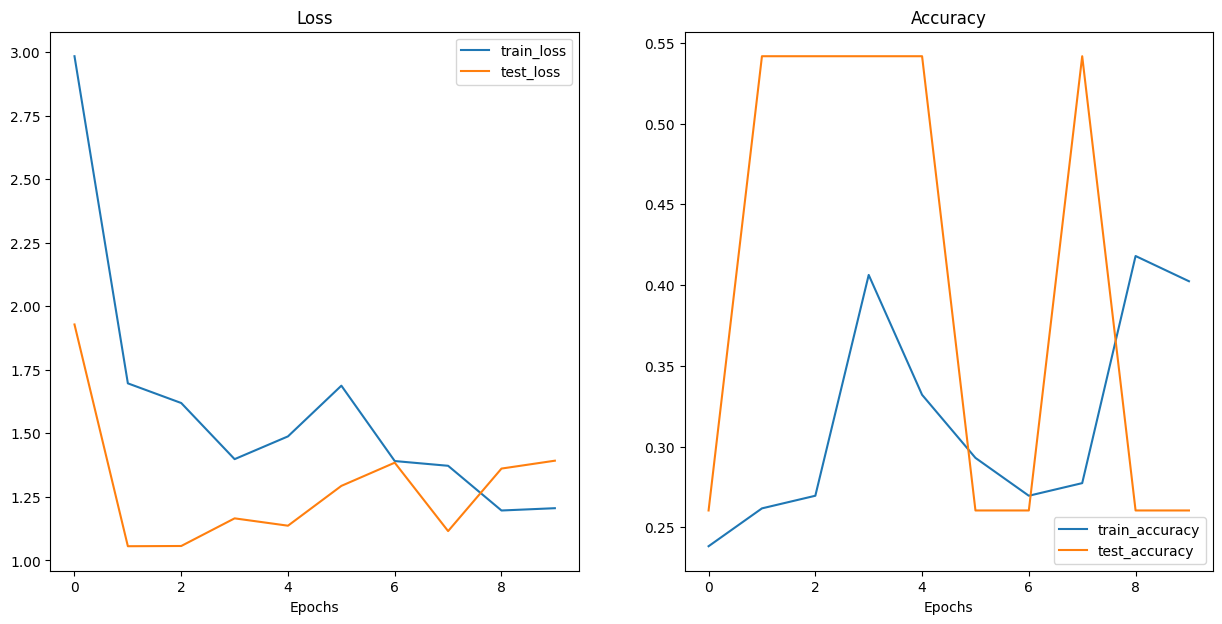

In [52]:
from helper_functions import plot_loss_curves

plot_loss_curves(result)

In [49]:
import torch 
import torchvision 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [50]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

In [51]:
summary(pretrained_vit)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

In [52]:
# Preparing data for the pretrained ViT model
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [55]:
# set up dataloaders 
from going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=16    
)

In [58]:
from going_modular import engine 

optimizer_pretrained = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3
)

pretrained_vit_result = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    epochs=10,
    optimizer=optimizer_pretrained,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2969 | train_acc: 0.9500 | test_loss: 0.1908 | test_acc: 0.9318
Epoch: 2 | train_loss: 0.1391 | train_acc: 0.9667 | test_loss: 0.1805 | test_acc: 0.9193
Epoch: 3 | train_loss: 0.1000 | train_acc: 0.9792 | test_loss: 0.1750 | test_acc: 0.9318
Epoch: 4 | train_loss: 0.0779 | train_acc: 0.9875 | test_loss: 0.1716 | test_acc: 0.9193
Epoch: 5 | train_loss: 0.0646 | train_acc: 0.9875 | test_loss: 0.1726 | test_acc: 0.9193
Epoch: 6 | train_loss: 0.0533 | train_acc: 0.9875 | test_loss: 0.1747 | test_acc: 0.9193
Epoch: 7 | train_loss: 0.1136 | train_acc: 0.9333 | test_loss: 0.1792 | test_acc: 0.9261
Epoch: 8 | train_loss: 0.0438 | train_acc: 1.0000 | test_loss: 0.2047 | test_acc: 0.9261
Epoch: 9 | train_loss: 0.0409 | train_acc: 1.0000 | test_loss: 0.1864 | test_acc: 0.9068
Epoch: 10 | train_loss: 0.0293 | train_acc: 1.0000 | test_loss: 0.1797 | test_acc: 0.9318


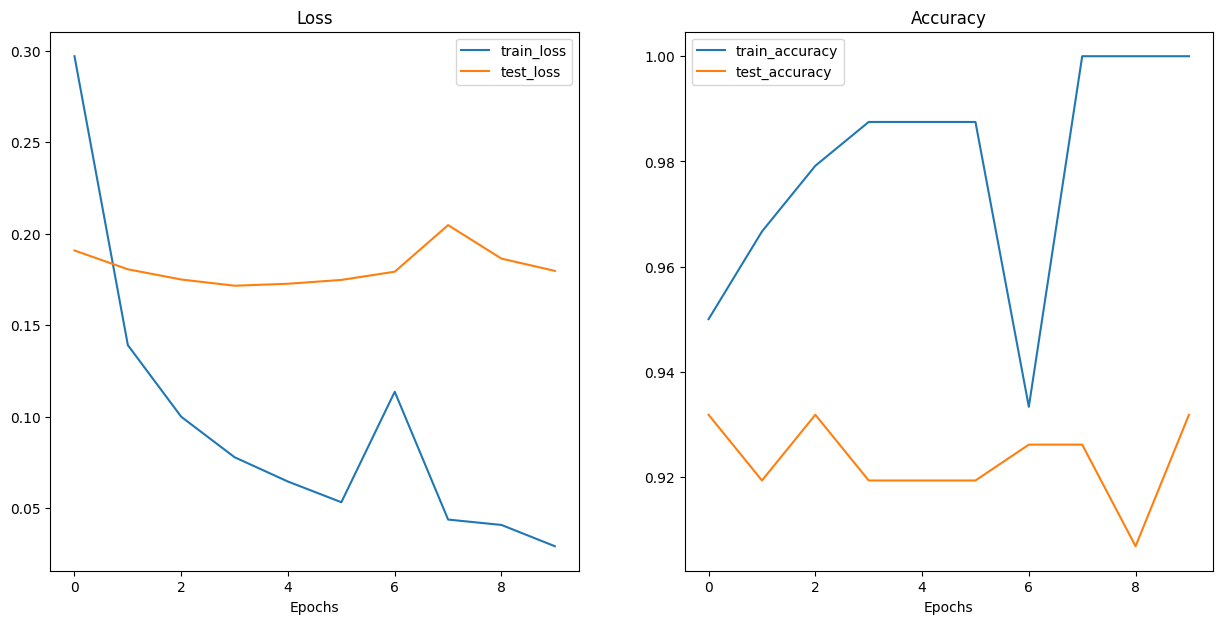

In [59]:
plot_loss_curves(pretrained_vit_result)

In [60]:
from going_modular import utils

utils.save_model(
    model=pretrained_vit,
    target_dir="models",
    model_name="08_paper_replicating_vit_pretrained.pt"
)

[INFO] Saving model to: models\08_paper_replicating_vit_pretrained.pt


In [64]:
from pathlib import Path 

# get model size in bytes
pretrained_vit_model_size = Path("./models/08_paper_replicating_vit_pretrained.pt").stat().st_size // (1024*1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB
